# Get the number of tokens

Inspired from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

In [78]:
import tiktoken
import json
import random
import pandas as pd
import tqdm
import importlib
import copy

In [76]:
def load_dataset(input_path: str, n_inputs: int = -1) -> list[dict]:
        """
        Load the galaxy-zoo json dataset. If specified, a random subset of the dataset is returned.
        """
        with open(input_path, 'r') as file:
            dataset = json.load(file)
        if 0 < n_inputs < len(dataset):
            return random.sample(dataset, n_inputs)
        else:
            return dataset
        
def load_module(path: str):
        """
        Allows to load variables from questions.py and prompt.py.
        """
        spec = importlib.util.spec_from_file_location("settings", path)
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)
        return module
        
def concat_conversation(entry: dict) -> str:
        conversation = ""
        for j in range(len(entry['conversations'])):
            message = entry['conversations'][j]['value']
            if isinstance(message, str):
                conversation += "User: " + message + "\n\n"

        return conversation

def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [77]:
input_file = '/home/michael/Workspace/datasets/galaxy_zoo/GZ_talk_comments_notes_urls_AISSAI.json'
prompt_file = "../scripts/prompt.py"

dataset = load_dataset(input_file, -1)
module = load_module(prompt_file)
prompt = module.PROMPT_DESC
questions = module.QUESTIONS_V0

In [83]:
num_tokens_from_string(prompt)

247

In [81]:
metadata = []
question = questions[0]

for entry in tqdm.tqdm(dataset):
    concat_entry = concat_conversation(entry)
    content = copy.deepcopy(prompt) % (concat_entry, question)
    n_tokens = num_tokens_from_string(content)
    n_caracters = len(content)
    id = entry['id']
    metadata.append({
        'id': id,
        'n_tokens': n_tokens,
        'n_caracters': n_caracters,
    })

metadata = pd.DataFrame(metadata)
metadata.head()


100%|██████████| 99591/99591 [00:14<00:00, 7042.98it/s]


,id,n_tokens,n_caracters
0,16215288,388,1698
1,16215291,266,1275
2,16215293,280,1360
3,16215294,303,1395
4,16215296,273,1304


array([[<Axes: title={'center': 'n_tokens'}>]], dtype=object)

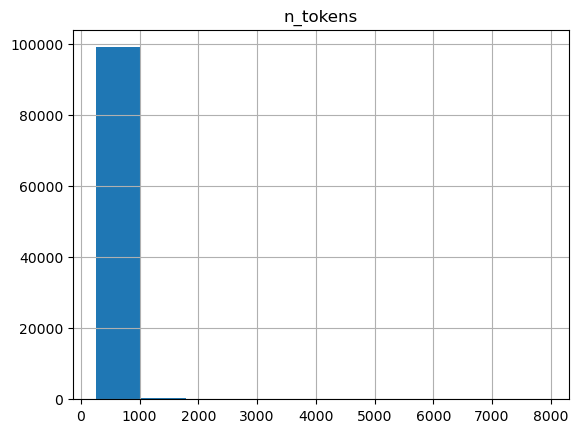

In [91]:
metadata.hist('n_tokens')

In [88]:
MAX_TOKENS = 2048

metadata['n_tokens'].apply(lambda x: x > MAX_TOKENS).sum()

70